In [1]:
%matplotlib inline
%run 'bin/notebook_utils.py'

In [2]:
# ??
exp5_sessions = pd.read_csv('../data/exp5/sessions.csv', index_col=0)
exp5_pilots = pd.read_csv('../data/exp5/pilots.csv', index_col=0)
exp5_units = pd.read_csv('../data/exp5/units.csv', index_col=0)

In [3]:
# Cleanup spurious runs
# exp4_sessions.drop('rp.session.login4.mturilli1.018122.0001', axis=0, inplace=True)
# exp4_sessions.drop('rp.session.login4.mturilli1.018122.0000', axis=0, inplace=True)
# exp4_sessions.drop('rp.session.login4.mturilli1.018127.0003', axis=0, inplace=True)

In [4]:
print 'Experiment 5: Baseline: Total number of successful runs: %s' % exp5_sessions.shape[0]
print 'Experiment 5: Baseline: Total number of pilots: %s' % exp5_pilots.shape[0]
print 'Experiment 5: Baseline: Total number of units: %s\n' % exp5_units.shape[0]

Experiment 5: Baseline: Total number of successful runs: 5
Experiment 5: Baseline: Total number of pilots: 5
Experiment 5: Baseline: Total number of units: 1920



In [5]:
exp5_sessions['nnode'] = exp5_sessions.ncore/24
exp5_sessions['list'] = exp5_sessions[['nunit','nnode']].astype(int, errors='ignore').astype('str').values.tolist()
exp5_sessions['nunitnode'] = exp5_sessions['list'].apply('/'.join)

exp5_sessions

,NEW,P_LRMS_QUEUING,P_LRMS_RUNNING,P_LRMS_SUBMITTING,P_PMGR_QUEUING,P_PMGR_SCHEDULING,TTC,U_AGENT_EXECUTING,U_AGENT_QUEUING,U_AGENT_QUEUING_EXEC,...,util_u_exec_app,util_u_exec_cu,util_u_exec_orte,util_u_exec_rp,util_u_pre_exec,util_u_total,util_u_unschedule,nnode,list,nunitnode
re.session.login2.hrlee.018147.0003,133.562120,3011.003309,16703.783260,6.373710,0.000525,0.037402,1.567938e+09,16453.616817,0.015481,1.770667,...,0,8.541749,0,1.836422,8.462652,16453.619948,0,35.0,"[132, 35]",132/35
re.session.login2.hrlee.018147.0001,495.097628,3608.793674,24659.628137,6.230410,0.000531,0.036359,1.567945e+09,23627.593601,0.043501,8.015864,...,0,25.385560,0,8.061999,25.345248,23627.597312,0,140.0,"[492, 140]",492/140
re.session.login2.hrlee.018146.0007,75.469565,59.245785,15775.005748,6.076735,0.000535,0.036421,1.567884e+09,15580.431276,0.009071,0.887519,...,0,5.483828,0,0.935412,5.423940,15580.503746,0,17.5,"[72, 17]",72/17
re.session.login2.hrlee.018148.0002,254.012380,55.764250,21048.058444,6.504254,0.000589,0.036269,1.568079e+09,20622.450147,0.031239,3.442707,...,0,15.102650,0,3.791120,14.916166,20622.456450,0,70.0,"[252, 70]",252/70
re.session.login2.hrlee.018149.0000,974.539780,989.211099,43255.107221,6.348993,0.000546,0.036582,1.568124e+09,24585.375036,0.085167,25.571293,...,0,46.831534,0,25.068296,46.799630,24585.378319,0,280.0,"[972, 280]",972/280


In [6]:
# Load sessions for Synapse experiment 1
ws_sras_exp5 = load_sessions_units(
    '../data',       # session directory  
    exp5_sessions,   # sessions
    sorted(exp5_sessions.nunit.unique().tolist()) # session nunits
)

In [7]:
import radical.analytics as ra
import radical.entk as re

exp5_entk_sessions = pd.DataFrame()

exp5_sobjs = []
for s in exp5_sessions.sid.to_list():
    exp5_sobjs.append(ra.Session(src='../data/exp5/', sid = s, stype='radical.entk'))
    
columns = []
for s in exp5_sobjs:
    for stage in s.filter(etype = 'stage', inplace=True).list(['etype', 'uid'])[1]:
        columns.append(stage)
columns = sorted(list(set(columns)))

data = {}
for s in exp5_sobjs:
    if s._sid != 're.session.login2.hrlee.018149.0000':
        data[s._sid] = []
        for stage in columns:
            data[s._sid].append(s.filter(etype='stage', uid=stage, inplace=False).duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULED},
                                                                                                  {ru.EVENT: 'state', ru.STATE: re.states.DONE}]))
            data[s._sid].append(s.filter(etype='stage', uid=stage, inplace=False).duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULING},
                                                                                                  {ru.EVENT: 'state', ru.STATE: re.states.SCHEDULED}]))

columns = pd.MultiIndex.from_product([columns, ['TTX', 'EnTK Overhead']])
exp5_stages = pd.DataFrame(data.values(), index=data.keys(), columns=columns)
exp5_stages['nunitnode'] = exp5_sessions.nunitnode
exp5_stages

stage.0000               stage.0001                 stage.0002                 stage.0003               nunitnode
                                              TTX EnTK Overhead        TTX EnTK Overhead          TTX EnTK Overhead          TTX EnTK Overhead          
re.session.login2.hrlee.018146.0007  12498.290328      0.790030  14.996861      0.670399  1335.082634      0.639422  1862.230564      0.636118     72/17
re.session.login2.hrlee.018147.0003  12171.990327      0.834178  20.529374      0.583221  2021.395433      0.589234  2427.235810      0.595579    132/35
re.session.login2.hrlee.018148.0002  12377.646605      0.988588  33.872156      0.585200  3456.640920      0.591447  5119.947983      0.584981    252/70
re.session.login2.hrlee.018147.0001  12934.887563      1.120682  57.523584      0.584304  6371.450154      0.590083  5145.087556      0.584379   492/140

In [8]:
import radical.analytics as ra
import radical.entk as re

exp6_entk_sessions = pd.DataFrame()

# re.session.login4.arvind.018147.0002.fsp.50ns.240MDs.tar.gz
# re.session.login4.arvind.018147.0003.fsp.50ns.480MDs.tar.gz
# re.session.login4.arvind.018148.0000.fsp.50ns.600MDs.tar.gz
# re.session.login4.arvind.018148.0001.fsp.50ns.960MDs.tar.gz

exp6_sessions = {'re.session.login4.arvind.018147.0002': '252/70',
                 're.session.login4.arvind.018147.0003': '492/140',
                 # 're.session.login4.arvind.018148.0000': '',
                 're.session.login4.arvind.018148.0001': '972/280'}

exp6_sobjs = []
for s in exp6_sessions.keys():
    exp6_sobjs.append(ra.Session(src='../data/exp6/', sid = s, stype='radical.entk'))
    
columns = []
for s in exp6_sobjs:
    for stage in s.filter(etype = 'stage', inplace=True).list(['etype', 'uid'])[1]:
        columns.append(stage)
columns = sorted(list(set(columns)))

data = {}
for s in exp6_sobjs:
    if s._sid != 're.session.login2.hrlee.018149.0000':
        data[s._sid] = []
        for stage in columns:
            data[s._sid].append(s.filter(etype='stage', uid=stage, inplace=False).duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULED},
                                                                                                  {ru.EVENT: 'state', ru.STATE: re.states.DONE}]))
            data[s._sid].append(s.filter(etype='stage', uid=stage, inplace=False).duration(event=[{ru.EVENT: 'state', ru.STATE: re.states.SCHEDULING},
                                                                                                  {ru.EVENT: 'state', ru.STATE: re.states.SCHEDULED}]))

columns = pd.MultiIndex.from_product([columns, ['TTX', 'EnTK Overhead']])
exp6_stages = pd.DataFrame(data.values(), index=data.keys(), columns=columns)
# exp6_stages['nunitnode'] = exp6_sessions.nunitnode
exp6_stages['nunitnode'] = exp6_stages.index.map(exp6_sessions)
exp6_stages['nunit'] = exp6_stages["nunitnode"].str.split("/", n = 1, expand = True)[1]
exp6_stages['nunit']  = exp6_stages['nunit'].astype(int)
exp6_stages = exp6_stages.sort_values('nunit')
exp6_stages

stage.0000               stage.0001                 stage.0002                  stage.0003               nunitnode nunit
                                              TTX EnTK Overhead        TTX EnTK Overhead          TTX EnTK Overhead           TTX EnTK Overhead                
re.session.login4.arvind.018147.0002  3586.892423    226.377542  27.075608      1.278982  1650.538092      9.650554   2479.900518      1.280587    252/70    70
re.session.login4.arvind.018147.0003  3988.017347    450.621664  38.916599      1.395499  2720.709884      9.650944   6517.833262      1.280503   492/140   140
re.session.login4.arvind.018148.0001  5175.895878    893.216982  89.773069      1.278589  4700.140955      9.532422  26793.261473      1.278133   972/280   280

/Users/mturilli/Virtualenvs/hyperspace/lib/python2.7/site-packages/matplotlib/font_manager.py:1331: UserWarning: findfont: Font family [u'serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


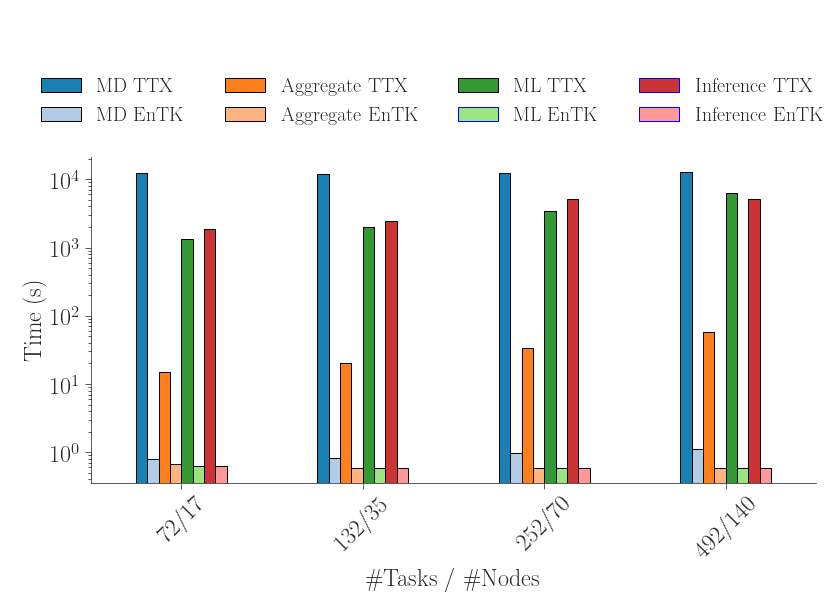

In [9]:
from matplotlib.patches import Patch
fig, ax = fig_setup(figsize=(13,6))

exp5_stages.plot.bar(
    x = 'nunitnode', 
    logy=True,  
    ax = ax, color = [tableau20[0],tableau20[1],
                      tableau20[2],tableau20[3],
                      tableau20[4],tableau20[5],
                      tableau20[6],tableau20[7]], rot = 45, legend=False)

ax.set_xlabel('\#Tasks / \#Nodes')
ax.set_ylabel('Time (s)')
# ax.set_ylim(0)
# ax.set_xlim(-1.5)

legend_elements = [ Patch(facecolor=tableau20[0], edgecolor='black', label='MD  TTX'),
                    Patch(facecolor=tableau20[1], edgecolor='black', label='MD EnTK'),
                    Patch(facecolor=tableau20[2], edgecolor='black', label='Aggregate TTX'),
                    Patch(facecolor=tableau20[3], edgecolor='black', label='Aggregate EnTK'),
                    Patch(facecolor=tableau20[4], edgecolor='black', label='ML TTX'),
                    Patch(facecolor=tableau20[5], edgecolor='b', label='ML EnTK'),
                    Patch(facecolor=tableau20[6], edgecolor='b', label='Inference TTX'),
                    Patch(facecolor=tableau20[7], edgecolor='b', label='Inference EnTK')]

fig.legend(handles=legend_elements,
           loc='upper left',
           bbox_to_anchor=(0.025, 1.25),
           fontsize=20,
           ncol=4)

plt.savefig('figures/stage_ttx_entk_overhead_log.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stage_ttx_entk_overhead_log.png', dpi=300, bbox_inches='tight')

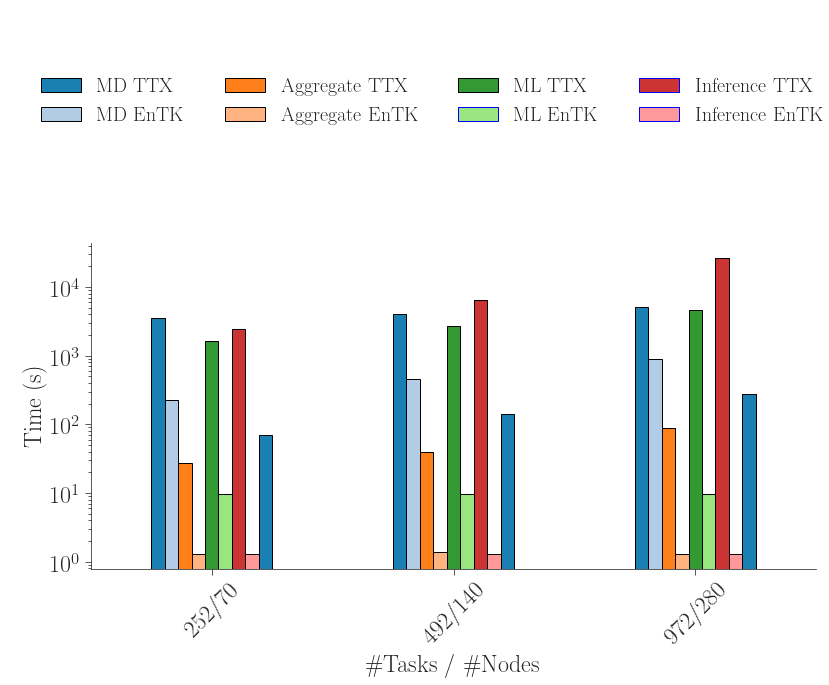

In [10]:
from matplotlib.patches import Patch
fig, ax = fig_setup(figsize=(13,6))

exp6_stages.plot.bar(
    x = 'nunitnode', 
    logy=True,  
    ax = ax, color = [tableau20[0],tableau20[1],
                      tableau20[2],tableau20[3],
                      tableau20[4],tableau20[5],
                      tableau20[6],tableau20[7]], rot = 45, legend=False)

ax.set_xlabel('\#Tasks / \#Nodes')
ax.set_ylabel('Time (s)')

legend_elements = [ Patch(facecolor=tableau20[0], edgecolor='black', label='MD  TTX'),
                    Patch(facecolor=tableau20[1], edgecolor='black', label='MD EnTK'),
                    Patch(facecolor=tableau20[2], edgecolor='black', label='Aggregate TTX'),
                    Patch(facecolor=tableau20[3], edgecolor='black', label='Aggregate EnTK'),
                    Patch(facecolor=tableau20[4], edgecolor='black', label='ML TTX'),
                    Patch(facecolor=tableau20[5], edgecolor='b', label='ML EnTK'),
                    Patch(facecolor=tableau20[6], edgecolor='b', label='Inference TTX'),
                    Patch(facecolor=tableau20[7], edgecolor='b', label='Inference EnTK')]

fig.legend(handles=legend_elements,
           loc='upper left',
           bbox_to_anchor=(0.025, 1.45),
           fontsize=20,
           ncol=4)

plt.savefig('figures/stage_ttx_entk_overhead_exp6.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stage_ttx_entk_overhead_exp6.png', dpi=300, bbox_inches='tight')

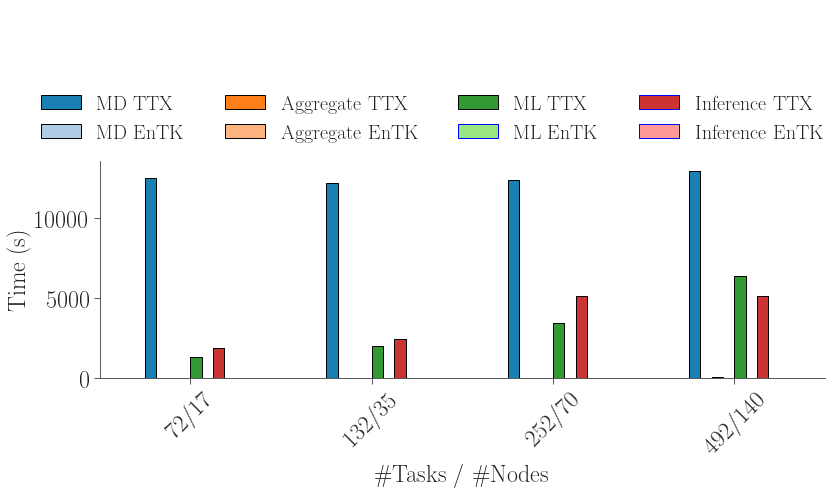

In [11]:
from matplotlib.patches import Patch
fig, ax = fig_setup(figsize=(13,4))

exp5_stages.plot.bar(
    x = 'nunitnode', 
#     logy = True,  
    ax = ax, color = [tableau20[0],tableau20[1],
                      tableau20[2],tableau20[3],
                      tableau20[4],tableau20[5],
                      tableau20[6],tableau20[7]], 
    rot = 45, 
    legend = False)

ax.set_xlabel('\#Tasks / \#Nodes')
ax.set_ylabel('Time (s)')

legend_elements = [ Patch(facecolor=tableau20[0], edgecolor='black', label='MD  TTX'),
                    Patch(facecolor=tableau20[1], edgecolor='black', label='MD EnTK'),
                    Patch(facecolor=tableau20[2], edgecolor='black', label='Aggregate TTX'),
                    Patch(facecolor=tableau20[3], edgecolor='black', label='Aggregate EnTK'),
                    Patch(facecolor=tableau20[4], edgecolor='black', label='ML TTX'),
                    Patch(facecolor=tableau20[5], edgecolor='b', label='ML EnTK'),
                    Patch(facecolor=tableau20[6], edgecolor='b', label='Inference TTX'),
                    Patch(facecolor=tableau20[7], edgecolor='b', label='Inference EnTK')]

fig.legend(handles=legend_elements,
           loc='upper left',
           bbox_to_anchor=(0.025, 1.45),
           fontsize=20,
           ncol=4)

plt.savefig('figures/stage_ttx_entk_overhead.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stage_ttx_entk_overhead.png', dpi=300, bbox_inches='tight')

In [12]:
exp5_data_raw = pd.read_csv('../data/exp5/60mdruns.output.csv', index_col=0)

exp5_data_60 = exp5_data_raw.groupby('stage_name').aggregate(
                {'output_file_count'         : ['sum','mean','std'],
                 'output_filesize_byte'      : ['sum','mean','std'],
                 'input_nanosecond'          : ['mean','std'],
                 'output_frame_count'        : ['sum','mean','std'],
                 'report_interval_picosecond': ['mean','std']
                })

# exp5_ws.rename({'P_LRMS_QUEUING' :'TTQ'}, axis='columns', inplace=True)
# exp5_ws.rename({'U_AGENT_QUEUING':'Agent queueing'}, axis='columns', inplace=True)
# exp5_data.loc['generate_MD_stage']['output_filesize_byte'].plot.bar()
exp5_data_60

report_interval_picosecond      input_nanosecond      output_filesize_byte                            output_file_count           output_frame_count           
                                                 mean  std             mean  std                  sum          mean          std               sum mean  std                sum  mean  std
stage_name                                                                                                                                                                                
generate_MD_stage                                50.0  0.0             50.0  0.0          15541149653  2.590192e+08    20.228434               240    4  0.0              60000  1000  0.0
generate_ML_stage                                 0.0  0.0              0.0  0.0            445385312  4.453853e+07  9457.507832                30    3  0.0                  0     0  0.0
generate_aggregating_stage                       50.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN
generate_interfacing_stage                        0.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN

In [13]:
exp5_data_raw = pd.read_csv('../data/exp5/120mdruns.output.csv', index_col=0)

exp5_data_120 = exp5_data_raw.groupby('stage_name').aggregate(
                {'output_file_count'         : ['sum','mean','std'],
                 'output_filesize_byte'      : ['sum','mean','std'],
                 'input_nanosecond'          : ['mean','std'],
                 'output_frame_count'        : ['sum','mean','std'],
                 'report_interval_picosecond': ['mean','std']
                })

# exp5_ws.rename({'P_LRMS_QUEUING' :'TTQ'}, axis='columns', inplace=True)
# exp5_ws.rename({'U_AGENT_QUEUING':'Agent queueing'}, axis='columns', inplace=True)
# exp5_data.loc['generate_MD_stage']['output_filesize_byte'].plot.bar()
exp5_data_120

report_interval_picosecond      input_nanosecond      output_filesize_byte                            output_file_count           output_frame_count           
                                                 mean  std             mean  std                  sum          mean          std               sum mean  std                sum  mean  std
stage_name                                                                                                                                                                                
generate_MD_stage                                50.0  0.0             50.0  0.0          31082299376  2.590192e+08    20.275387               480    4  0.0             120000  1000  0.0
generate_ML_stage                                 0.0  0.0              0.0  0.0            445385312  4.453853e+07  9457.507832                30    3  0.0                  0     0  0.0
generate_aggregating_stage                       50.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN
generate_interfacing_stage                        0.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN

In [14]:
exp5_data_raw = pd.read_csv('../data/exp5/240mdruns.output.csv', index_col=0)

exp5_data_240 = exp5_data_raw.groupby('stage_name').aggregate(
                {'output_file_count'         : ['sum','mean','std'],
                 'output_filesize_byte'      : ['sum','mean','std'],
                 'input_nanosecond'          : ['mean','std'],
                 'output_frame_count'        : ['sum','mean','std'],
                 'report_interval_picosecond': ['mean','std']
                })

# exp5_ws.rename({'P_LRMS_QUEUING' :'TTQ'}, axis='columns', inplace=True)
# exp5_ws.rename({'U_AGENT_QUEUING':'Agent queueing'}, axis='columns', inplace=True)
# exp5_data.loc['generate_MD_stage']['output_filesize_byte'].plot.bar()
exp5_data_240

report_interval_picosecond      input_nanosecond      output_filesize_byte                            output_file_count           output_frame_count           
                                                 mean  std             mean  std                  sum          mean          std               sum mean  std                sum  mean  std
stage_name                                                                                                                                                                                
generate_MD_stage                                50.0  0.0             50.0  0.0          62164598148  2.590192e+08    19.454421               960    4  0.0             240000  1000  0.0
generate_ML_stage                                 0.0  0.0              0.0  0.0            445385312  4.453853e+07  9457.507832                30    3  0.0                  0     0  0.0
generate_aggregating_stage                       50.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN
generate_interfacing_stage                        0.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN

In [15]:
exp5_data_raw = pd.read_csv('../data/exp5/480mdruns.output.csv', index_col=0)

exp5_data_480 = exp5_data_raw.groupby('stage_name').aggregate(
                {'output_file_count'         : ['sum','mean','std'],
                 'output_filesize_byte'      : ['sum','mean','std'],
                 'input_nanosecond'          : ['mean','std'],
                 'output_frame_count'        : ['sum','mean','std'],
                 'report_interval_picosecond': ['mean','std']
                })

# exp5_ws.rename({'P_LRMS_QUEUING' :'TTQ'}, axis='columns', inplace=True)
# exp5_ws.rename({'U_AGENT_QUEUING':'Agent queueing'}, axis='columns', inplace=True)
# exp5_data.loc['generate_MD_stage']['output_filesize_byte'].plot.bar()
exp5_data_480

report_interval_picosecond      input_nanosecond      output_filesize_byte                            output_file_count           output_frame_count           
                                                 mean  std             mean  std                  sum          mean          std               sum mean  std                sum  mean  std
stage_name                                                                                                                                                                                
generate_MD_stage                                50.0  0.0             50.0  0.0         124329198062  2.590192e+08    18.972015              1920    4  0.0             480000  1000  0.0
generate_ML_stage                                 0.0  0.0              0.0  0.0            445385312  4.453853e+07  9457.507832                30    3  0.0                  0     0  0.0
generate_aggregating_stage                       50.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN
generate_interfacing_stage                        0.0  NaN              0.0  NaN                    0  0.000000e+00          NaN                 0    0  NaN                  0     0  NaN

In [16]:
columns = ['stage.0000', 'stage.0001']
index = exp5_stages.index

data = {'re.session.login2.hrlee.018146.0007': [exp5_data_60.loc['generate_MD_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_60.loc['generate_MD_stage']['output_filesize_byte']['mean'], 
                                                exp5_data_60.loc['generate_MD_stage']['output_frame_count']['sum'],
                                                exp5_data_60.loc['generate_ML_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_60.loc['generate_ML_stage']['output_filesize_byte']['mean'],
                                                0 ],
        're.session.login2.hrlee.018147.0003': [exp5_data_120.loc['generate_MD_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_120.loc['generate_MD_stage']['output_filesize_byte']['mean'], 
                                                exp5_data_120.loc['generate_MD_stage']['output_frame_count']['sum'],
                                                exp5_data_120.loc['generate_ML_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_120.loc['generate_ML_stage']['output_filesize_byte']['mean'],
                                                0 ],
        're.session.login2.hrlee.018148.0002': [exp5_data_240.loc['generate_MD_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_240.loc['generate_MD_stage']['output_filesize_byte']['mean'], 
                                                exp5_data_240.loc['generate_MD_stage']['output_frame_count']['sum'],
                                                exp5_data_240.loc['generate_ML_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_240.loc['generate_ML_stage']['output_filesize_byte']['mean'],
                                                0 ],
        're.session.login2.hrlee.018147.0001': [exp5_data_480.loc['generate_MD_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_480.loc['generate_MD_stage']['output_filesize_byte']['mean'], 
                                                exp5_data_480.loc['generate_MD_stage']['output_frame_count']['sum'],
                                                exp5_data_480.loc['generate_ML_stage']['output_filesize_byte']['sum'], 
                                                exp5_data_480.loc['generate_ML_stage']['output_filesize_byte']['mean'],
                                                0 ] }

columns = pd.MultiIndex.from_product([columns, ['Total Data', 'Mean Data per Task', 'Total Frames']])
exp5_data = pd.DataFrame(data.values(), index=data.keys(), columns=columns)
exp5_data['nunitnode'] = exp5_sessions.nunitnode
exp5_data['nunit'] = exp5_sessions.nunit
exp5_data = exp5_data.sort_values('nunit')
exp5_data

stage.0000                                   stage.0001                                 nunitnode nunit
                                       Total Data Mean Data per Task Total Frames   Total Data Mean Data per Task Total Frames                
re.session.login2.hrlee.018146.0007  1.554115e+10       2.590192e+08      60000.0  445385312.0         44538531.2            0     72/17    72
re.session.login2.hrlee.018147.0003  3.108230e+10       2.590192e+08     120000.0  445385312.0         44538531.2            0    132/35   132
re.session.login2.hrlee.018148.0002  6.216460e+10       2.590192e+08     240000.0  445385312.0         44538531.2            0    252/70   252
re.session.login2.hrlee.018147.0001  1.243292e+11       2.590192e+08     480000.0  445385312.0         44538531.2            0   492/140   492

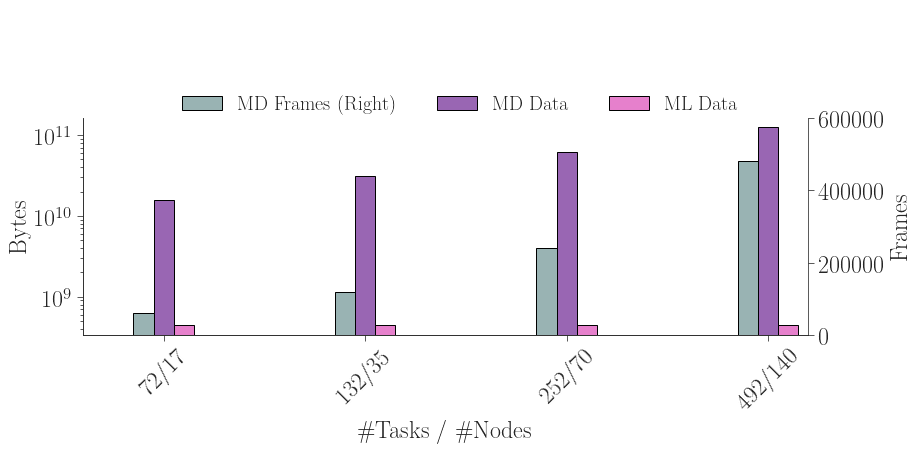

In [17]:
from matplotlib.patches import Patch
fig, ax = fig_setup(figsize=(13,4))
ax2 = ax.twinx()
ax2.spines["top"].set_visible(False)

data = exp5_data.loc[:, (['stage.0000','stage.0001'], ['Total Data'])].copy()
data['nunitnode'] = exp5_sessions.nunitnode
data.plot.bar(
    x = 'nunitnode', 
    ax = ax, 
    color = [tableau20[8],tableau20[12]],
    rot = 45,
    width = 0.2,
    logy = True, 
    legend = False,
    position = 0.25)

frames = exp5_data.loc[:, (['stage.0000'], ['Total Frames'])].copy()
frames['nunitnode'] = exp5_sessions.nunitnode
frames.plot.bar(
    x = 'nunitnode',
    ax = ax2, 
    color = tableau20[22],
    width = 0.1,
    legend = False,
    position = 1.5)


ax.set_xlabel('\#Tasks / \#Nodes')
ax.set_ylabel('Bytes')
ax2.set_ylabel('Frames')
ax2.set_ylim(0,600000)

legend_elements = [ Patch(facecolor=tableau20[22], edgecolor='black', label='MD Frames (Right)'),
                    Patch(facecolor=tableau20[8], edgecolor='black', label='MD Data'),
                    Patch(facecolor=tableau20[12], edgecolor='black', label='ML Data')]

fig.legend(handles=legend_elements,
           loc='upper left',
           bbox_to_anchor=(0.175, 1.3),
           fontsize=20,
           ncol=4)

plt.savefig('figures/stage_data_frame.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/stage_data_frame.png', dpi=300, bbox_inches='tight')

In [18]:
import pickle

loss_fsp = pickle.load(open('../data/exp6/loss_fsp.pkl', 'r'))
loss_vhp = pickle.load(open('../data/exp6/loss_vhp.pkl', 'r'))

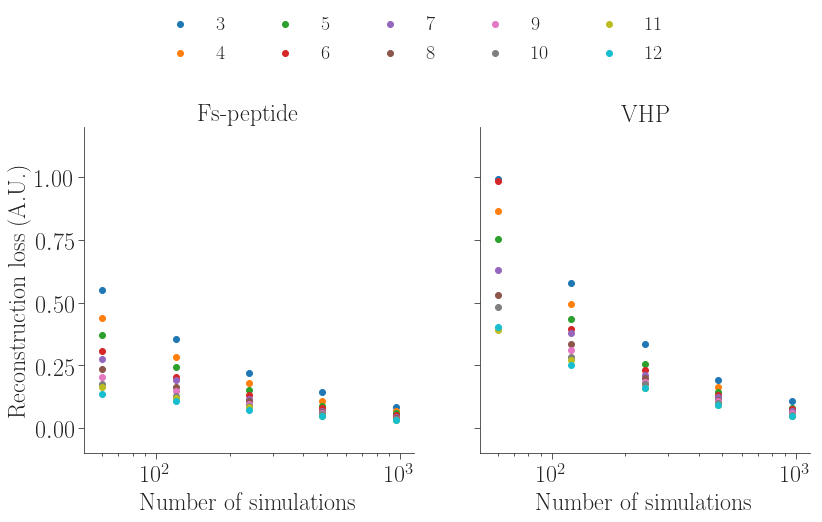

In [20]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 6), sharey=True)

ax1.spines["top"].set_visible(False)
ax1.spines["right"].set_visible(False)
ax1.get_xaxis().tick_bottom()
ax1.get_yaxis().tick_left()

ax2.spines["top"].set_visible(False)
ax2.spines["right"].set_visible(False)
ax2.get_xaxis().tick_bottom()
ax2.get_yaxis().tick_left()

for ax, loss_dict in zip((ax1, ax2), (loss_fsp, loss_vhp)): 
    for loss in loss_dict: 
        loss_profile = np.array(np.array(loss_dict[loss].items()))
        ax.scatter(loss_profile[:,0], loss_profile[:,1]/loss_profile[:,0], label=loss)  
        ax.set_xscale('log') 
        ax.set_xlabel('Number of simulations')

ax1.legend(loc='upper left', ncol=5, bbox_to_anchor=(0.175, 1.4), fontsize=20)

ax1.set_title('Fs-peptide') 
ax2.set_title('VHP')
ax1.set_ylabel('Reconstruction loss (A.U.)') 
ax2.set_ylim(-0.1, 1.2)

plt.savefig('figures/loss.pdf', dpi=300, bbox_inches='tight')
plt.savefig('figures/loss.png', dpi=300, bbox_inches='tight')